In [4]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
spark = SparkSession.builder.master('local[4]').appName('ml').getOrCreate()

# Dataset - 1(bank-full.csv)

In [8]:
data_1 = spark.read.csv('bank-full.csv',sep = ";",header=True,inferSchema=True)

In [9]:
data_1.count()

45211

### Converting to Pandas

In [10]:
pdf_1=data_1.toPandas()

#### to display maximum no. of columns

In [11]:
pd.pandas.set_option('display.max_columns',None)

In [12]:
pdf_1.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### renamed column for unform naming before concat operation

In [13]:
new_cols = ["emp_var_rate", "cons_price_idx", "cons_conf_idx", "euribor_3m", "nr_employed"]
col_no = 16
for column in new_cols:
    pdf_1.insert(col_no, column, value = np.nan)
    col_no = col_no + 1

In [14]:
pdf_1.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,NaN,NaN,NaN,NaN,NaN,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,NaN,NaN,NaN,NaN,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,NaN,NaN,NaN,NaN,NaN,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,NaN,NaN,NaN,NaN,NaN,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,NaN,NaN,NaN,NaN,NaN,no


## Adding year mapper function to add year in dataset - 1(bank - full.csv)

In [15]:
def year_mapper(data, start_yr):
    month_lst = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]

    # Make a copy of the original dataframe
    new_data = data.copy()

    # Insert a new "year" column filled with zeros
    new_data.insert(loc=0, column="year", value=0)

    # Set the first year to the start year
    current_year = int(start_yr)
    new_data.at[0, "year"] = current_year

    # Loop through the rows of the dataframe, updating the year column when the month changes
    for i in range(1, len(new_data)):
        # If the current month is earlier in the year than the previous month, increment the year
        if month_lst.index(new_data["month"][i]) < month_lst.index(new_data["month"][i-1]):
            current_year += 1

        new_data.at[i, "year"] = current_year

        # If the current year exceeds the end year, break out of the loop
        if current_year > 2010:
            break

    return new_data

In [16]:
result_bankfull = year_mapper( data = pdf_1, start_yr = 2008)
result_bankfull.head()

,year,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y
0,2008,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,NaN,NaN,NaN,NaN,NaN,no
1,2008,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,NaN,NaN,NaN,NaN,NaN,no
2,2008,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,NaN,NaN,NaN,NaN,NaN,no
3,2008,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,NaN,NaN,NaN,NaN,NaN,no
4,2008,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,NaN,NaN,NaN,NaN,NaN,no


In [17]:
result_bankfull["year"].value_counts()

2008    27729
2009    14862
2010     2620
Name: year, dtype: int64

### Mapper function to insert indexes value into columns 

In [18]:
def map_index(data):
    
    index_2008 = {"may":{"emp_var_rate":1.1, "cons_price_idx":93.994, "cons_conf_idx":-36.4, "euribor_3m":4.85, "nr_employed":5191},
             "jun":{"emp_var_rate":1.4, "cons_price_idx":94.465, "cons_conf_idx":-41.8, "euribor_3m":4.86, "nr_employed":5228.1},
             "jul":{"emp_var_rate":1.4, "cons_price_idx":93.918, "cons_conf_idx":-42.7, "euribor_3m":4.96, "nr_employed":5228.1},
             "aug":{"emp_var_rate":1.4, "cons_price_idx":93.444, "cons_conf_idx":-36.1, "euribor_3m":4.965, "nr_employed":5228.1},
             "oct":{"emp_var_rate":-0.1, "cons_price_idx":93.798, "cons_conf_idx":-40.4, "euribor_3m":5, "nr_employed":5195.8},
             "nov":{"emp_var_rate":-0.1, "cons_price_idx":93.2, "cons_conf_idx":-42, "euribor_3m":4.406, "nr_employed":5195.8},
             "dec":{"emp_var_rate":-0.2, "cons_price_idx":92.75, "cons_conf_idx":-45.9, "euribor_3m":3.563, "nr_employed":5176.3}}
    
    index_2009 = {"jan":{"emp_var_rate":-0.2, "nr_employed":5176.3},
              "feb":{"emp_var_rate":-0.2, "nr_employed":5176.3},
              "mar":{"emp_var_rate":-1.8, "cons_price_idx":92.84, "cons_conf_idx":-50, "euribor_3m":1.811, "nr_employed":5099.1},
              "apr":{"emp_var_rate":-1.8, "cons_price_idx":93.075, "cons_conf_idx":-47.1, "euribor_3m":1.498, "nr_employed":5099.1},
              "may":{"emp_var_rate":-1.8, "cons_price_idx":92.89, "cons_conf_idx":-46.2, "euribor_3m":1.334, "nr_employed":5099.1},
             "jun":{"emp_var_rate":-2.9, "cons_price_idx":92.963, "cons_conf_idx":-40.8, "euribor_3m":1.26, "nr_employed":5076.2},
             "jul":{"emp_var_rate":-2.9, "cons_price_idx":93.469, "cons_conf_idx":-33.6, "euribor_3m":1.072, "nr_employed":5076.2},
             "aug":{"emp_var_rate":-2.9, "cons_price_idx":92.201, "cons_conf_idx":-31.4, "euribor_3m":0.884, "nr_employed":5076.2},
             "sep":{"emp_var_rate":-3.4, "cons_price_idx":92.379, "cons_conf_idx":-29.8, "euribor_3m":0.813, "nr_employed":5017.5},
             "oct":{"emp_var_rate":-3.4, "cons_price_idx":92.431, "cons_conf_idx":-26.9, "euribor_3m":0.754, "nr_employed":5017.5},
             "nov":{"emp_var_rate":-3.4, "cons_price_idx":92.649, "cons_conf_idx":-30.1, "euribor_3m":0.722, "nr_employed":5017.5},
             "dec":{"emp_var_rate":-3, "cons_price_idx":92.713, "cons_conf_idx":-33, "euribor_3m":0.718, "nr_employed":5023.5}}
    
    index_2010 = {"jan":{"emp_var_rate":-3, "nr_employed":5023.5},
              "feb":{"emp_var_rate":-3, "nr_employed":5023.5},
               "mar":{"emp_var_rate":-1.8, "cons_price_idx":92.369, "cons_conf_idx":-34.8, "euribor_3m":0.655, "nr_employed":5008.7},
              "apr":{"emp_var_rate":-1.8, "cons_price_idx":93.749, "cons_conf_idx":-34.6, "euribor_3m":0.64, "nr_employed":5008.7},
              "may":{"emp_var_rate":-1.8, "cons_price_idx":93.876, "cons_conf_idx":-40, "euribor_3m":0.668, "nr_employed":5008.7},
             "jun":{"emp_var_rate":-1.7, "cons_price_idx":94.055, "cons_conf_idx":-39.8, "euribor_3m":0.704, "nr_employed":4991.6},
             "jul":{"emp_var_rate":-1.7, "cons_price_idx":94.215, "cons_conf_idx":-40.3, "euribor_3m":0.79, "nr_employed":4991.6},
             "aug":{"emp_var_rate":-1.7, "cons_price_idx":94.027, "cons_conf_idx":-38.3, "euribor_3m":0.898, "nr_employed":4991.6},
             "sep":{"emp_var_rate":-1.1, "cons_price_idx":94.199, "cons_conf_idx":-37.5, "euribor_3m":0.886, "nr_employed":4963.6},
             "oct":{"emp_var_rate":-1.1, "cons_price_idx":94.601, "cons_conf_idx":-49.5, "euribor_3m":0.959, "nr_employed":4963.6},
             "nov":{"emp_var_rate":-1.1, "cons_price_idx":94.767, "cons_conf_idx":-50.8, "euribor_3m":1.05, "nr_employed":4963.6}}
    
    new_data = data.copy()
    indx = [index_2008, index_2009, index_2010]
    years = [2008, 2009, 2010]

    for i in range(0 , len(years)):
        for months, indexes in indx[i].items():
            for index, index_val in indexes.items():
                new_data.loc[(new_data['year'] == years[i]) & (new_data['month'] == months), index] = index_val
    return new_data            

In [19]:
bank_full = map_index(data = result_bankfull)
bank_full.head()

,year,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y
0,2008,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no
1,2008,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no
2,2008,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no
3,2008,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no
4,2008,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no


In [20]:
bank_full.count()

year              45211
age               45211
job               45211
marital           45211
education         45211
default           45211
balance           45211
housing           45211
loan              45211
contact           45211
day               45211
month             45211
duration          45211
campaign          45211
pdays             45211
previous          45211
poutcome          45211
emp_var_rate      45211
cons_price_idx    41159
cons_conf_idx     41159
euribor_3m        41159
nr_employed       45211
y                 45211
dtype: int64

### Adding date column

In [21]:
def get_date(month, year, day_of_week_str):
    year = int(year)
    
    month_lst = [ "haha",
               "jan", "feb", "mar", "apr",
               "may", "jun", "jul", "aug",
               "sep", "oct", "nov", "dec"]
    
    day_of_week_abbr=day_of_week_str.capitalize()
    # Get the abbreviated name of the day of the week
    day_of_week_abbr = day_of_week_abbr[:3]

    # Get the day of the week number
    day_of_week = list(calendar.day_abbr).index(day_of_week_abbr)
    month_num = month_lst.index(month)
    
    # Iterate over the days in the month and find the first day that matches the day of the week
    for day in range(1, calendar.monthrange(year, month_num)[1] + 1):
        if calendar.weekday(year, month_num, day) == day_of_week:
            return f"{day:02}"
    return None



def map_date2(data):
    # Make a copy of the original dataframe
    new_data = data.copy()
    
    # Insert a new "date" column filled with zeros
    new_data.insert(loc=10, column="date", value=0)
    
    month_lst = [ "haha",
               "jan", "feb", "mar", "apr",
               "may", "jun", "jul", "aug",
               "sep", "oct", "nov", "dec"]
    
    # Loop through the rows of the dataframe, updating the date column
    for i in range(0,len(new_data)):
        day = int(new_data["day"][i])
        new_data.at[i, "date"] = str(new_data["year"][i]) + "-" + \
        str( month_lst.index(new_data["month"][i]) ) + "-" + \
        str(f"{day:02}")
    return new_data


In [22]:
res_full_date = map_date2(data = bank_full)
res_full_date.head()

,year,age,job,marital,education,default,balance,housing,loan,contact,date,day,month,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y
0,2008,58,management,married,tertiary,no,2143,yes,no,unknown,2008-5-05,5,may,261,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no
1,2008,44,technician,single,secondary,no,29,yes,no,unknown,2008-5-05,5,may,151,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no
2,2008,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,2008-5-05,5,may,76,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no
3,2008,47,blue-collar,married,unknown,no,1506,yes,no,unknown,2008-5-05,5,may,92,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no
4,2008,33,unknown,single,unknown,no,1,no,no,unknown,2008-5-05,5,may,198,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no


In [23]:
res_full_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            45211 non-null  int64  
 1   age             45211 non-null  int32  
 2   job             45211 non-null  object 
 3   marital         45211 non-null  object 
 4   education       45211 non-null  object 
 5   default         45211 non-null  object 
 6   balance         45211 non-null  int32  
 7   housing         45211 non-null  object 
 8   loan            45211 non-null  object 
 9   contact         45211 non-null  object 
 10  date            45211 non-null  object 
 11  day             45211 non-null  int32  
 12  month           45211 non-null  object 
 13  duration        45211 non-null  int32  
 14  campaign        45211 non-null  int32  
 15  pdays           45211 non-null  int32  
 16  previous        45211 non-null  int32  
 17  poutcome        45211 non-null 

# Dataset - 2 (additional-full.csv)

In [24]:
dataset_2 = spark.read.csv('bank-additional-full.csv',sep = ";",header=True,inferSchema=True)

In [25]:
dataset_2.count()

41188

### Converting dataset to pandas

In [26]:
pdf_2 = dataset_2.toPandas()

In [27]:
pdf_2.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Replacing pdays 999 value to -1

In [28]:
pdf_2["pdays"] = pdf_2["pdays"].replace(999, -1)

In [29]:
pdf_2.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Renaming column names

In [30]:
old_col_list = ["emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]
for i in range(0, len(old_col_list)):
    pdf_2.rename(columns={old_col_list[i]: new_cols[i]}, inplace=True)

In [31]:
pdf_2.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Adding year mapper function to add year to dataset - 2(addition-full.csv)

In [32]:
def year_mapper(data, start_yr):
    month_lst = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]

    # Make a copy of the original dataframe
    new_data = data.copy()

    # Insert a new "year" column filled with zeros
    new_data.insert(loc=0, column="year", value=0)

    # Set the first year to the start year
    current_year = int(start_yr)
    new_data.at[0, "year"] = current_year

    # Loop through the rows of the dataframe, updating the year column when the month changes
    for i in range(1, len(new_data)):
        # If the current month is earlier in the year than the previous month, increment the year
        if month_lst.index(new_data["month"][i]) < month_lst.index(new_data["month"][i-1]):
            current_year += 1

        new_data.at[i, "year"] = current_year

        # If the current year exceeds the end year, break out of the loop
        if current_year > 2010:
            break

    return new_data

In [33]:
result_addition = year_mapper( data = pdf_2, start_yr = 2008)
result_addition.head()

,year,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y
0,2008,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,2008,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,2008,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,2008,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,2008,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [34]:
result_addition["year"].value_counts()

2008    27690
2009    11440
2010     2058
Name: year, dtype: int64

### adding date column to additional 

In [35]:
import calendar

def get_date(month, year, day_of_week_str):
    year = int(year)
    
    month_lst = [ "haha",
               "jan", "feb", "mar", "apr",
               "may", "jun", "jul", "aug",
               "sep", "oct", "nov", "dec"]
    
    day_of_week_abbr=day_of_week_str.capitalize()
    # Get the abbreviated name of the day of the week
    day_of_week_abbr = day_of_week_abbr[:3]

    # Get the day of the week number
    day_of_week = list(calendar.day_abbr).index(day_of_week_abbr)
    month_num = month_lst.index(month)
    
    # Iterate over the days in the month and find the first day that matches the day of the week
    for day in range(1, calendar.monthrange(year, month_num)[1] + 1):
        if calendar.weekday(year, month_num, day) == day_of_week:
            return f"{day:02}"
    return None


def map_date(data):
    # Make a copy of the original dataframe
    new_data = data.copy()
    
    # Insert a new "date" column filled with zeros
    new_data.insert(loc=10, column="date", value=0)
    
    month_lst = [ "haha",
               "jan", "feb", "mar", "apr",
               "may", "jun", "jul", "aug",
               "sep", "oct", "nov", "dec"]
    
    # Loop through the rows of the dataframe, updating the date column
    for i in range(0,len(new_data)):
        
        new_data.at[i, "date"] = str(new_data["year"][i]) + "-" + \
        str( month_lst.index(new_data["month"][i]) ) + "-" + \
        str( get_date(month = new_data["month"][i],
                      year = new_data["year"][i],
                      day_of_week_str = new_data["day_of_week"][i]) )
    return new_data


In [36]:
res_add_date = map_date(data=result_addition)
res_add_date.head()

,year,age,job,marital,education,default,housing,loan,contact,month,date,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y
0,2008,56,housemaid,married,basic.4y,no,no,no,telephone,may,2008-5-05,mon,261,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,2008,57,services,married,high.school,unknown,no,no,telephone,may,2008-5-05,mon,149,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,2008,37,services,married,high.school,no,yes,no,telephone,may,2008-5-05,mon,226,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,2008,40,admin.,married,basic.6y,no,no,no,telephone,may,2008-5-05,mon,151,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,2008,56,services,married,high.school,no,no,yes,telephone,may,2008-5-05,mon,307,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [37]:
old_edu = ["basic.4y", "high.school", "basic.6y", "basic.9y", "university.degree", "professional.course"]
new_edu = ["basic_4y", "high_school", "basic_6y", "basic_9y", "university_degree" ,"professional_course"]

for i in range(0,6):
    res_add_date.loc[(res_add_date['education'] == old_edu[i]), "education"] = new_edu[i]

In [38]:
res_add_date.head()

,year,age,job,marital,education,default,housing,loan,contact,month,date,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y
0,2008,56,housemaid,married,basic_4y,no,no,no,telephone,may,2008-5-05,mon,261,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,2008,57,services,married,high_school,unknown,no,no,telephone,may,2008-5-05,mon,149,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,2008,37,services,married,high_school,no,yes,no,telephone,may,2008-5-05,mon,226,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,2008,40,admin.,married,basic_6y,no,no,no,telephone,may,2008-5-05,mon,151,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,2008,56,services,married,high_school,no,no,yes,telephone,may,2008-5-05,mon,307,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [39]:
res_add_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            41188 non-null  int64  
 1   age             41188 non-null  int32  
 2   job             41188 non-null  object 
 3   marital         41188 non-null  object 
 4   education       41188 non-null  object 
 5   default         41188 non-null  object 
 6   housing         41188 non-null  object 
 7   loan            41188 non-null  object 
 8   contact         41188 non-null  object 
 9   month           41188 non-null  object 
 10  date            41188 non-null  object 
 11  day_of_week     41188 non-null  object 
 12  duration        41188 non-null  int32  
 13  campaign        41188 non-null  int32  
 14  pdays           41188 non-null  int32  
 15  previous        41188 non-null  int32  
 16  poutcome        41188 non-null  object 
 17  emp_var_rate    41188 non-null 

In [40]:
res_add_date = res_add_date.drop(["day_of_week","year","month"], axis=1)

In [41]:
res_full_date = res_full_date.drop(["balance","year","month","day"], axis=1)

In [42]:
res_add_date.head()

,age,job,marital,education,default,housing,loan,contact,date,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y
0,56,housemaid,married,basic_4y,no,no,no,telephone,2008-5-05,261,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high_school,unknown,no,no,telephone,2008-5-05,149,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high_school,no,yes,no,telephone,2008-5-05,226,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic_6y,no,no,no,telephone,2008-5-05,151,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high_school,no,no,yes,telephone,2008-5-05,307,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [43]:
res_full_date.head()

,age,job,marital,education,default,housing,loan,contact,date,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y
0,58,management,married,tertiary,no,yes,no,unknown,2008-5-05,261,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no
1,44,technician,single,secondary,no,yes,no,unknown,2008-5-05,151,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no
2,33,entrepreneur,married,secondary,no,yes,yes,unknown,2008-5-05,76,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no
3,47,blue-collar,married,unknown,no,yes,no,unknown,2008-5-05,92,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no
4,33,unknown,single,unknown,no,no,no,unknown,2008-5-05,198,1,-1,0,unknown,1.1,93.994,-36.4,4.85,5191.0,no


## Concatinating two datasets into one

In [44]:
frames  = [res_add_date, res_full_date]

bank_data = pd.concat(frames)

In [45]:
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,date,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y
0,56,housemaid,married,basic_4y,no,no,no,telephone,2008-5-05,261,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high_school,unknown,no,no,telephone,2008-5-05,149,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high_school,no,yes,no,telephone,2008-5-05,226,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic_6y,no,no,no,telephone,2008-5-05,151,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high_school,no,no,yes,telephone,2008-5-05,307,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [46]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86399 entries, 0 to 45210
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             86399 non-null  int32  
 1   job             86399 non-null  object 
 2   marital         86399 non-null  object 
 3   education       86399 non-null  object 
 4   default         86399 non-null  object 
 5   housing         86399 non-null  object 
 6   loan            86399 non-null  object 
 7   contact         86399 non-null  object 
 8   date            86399 non-null  object 
 9   duration        86399 non-null  int32  
 10  campaign        86399 non-null  int32  
 11  pdays           86399 non-null  int32  
 12  previous        86399 non-null  int32  
 13  poutcome        86399 non-null  object 
 14  emp_var_rate    86399 non-null  float64
 15  cons_price_idx  82347 non-null  float64
 16  cons_conf_idx   82347 non-null  float64
 17  euribor_3m      82347 non-null 

In [47]:
bank_data.describe()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed
count,86399.000000,86399.000000,86399.000000,86399.000000,86399.000000,86399.000000,82347.000000,82347.000000,82347.000000,86399.000000
mean,40.501372,258.221206,2.670286,20.681061,0.386127,0.052096,93.576799,-40.483621,3.638351,5166.518884
std,10.534861,258.362746,2.947825,75.269141,1.713060,1.552601,0.579494,4.625350,1.726092,71.346335
min,17.000000,0.000000,1.000000,-1.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,103.000000,1.000000,-1.000000,0.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000
50%,39.000000,180.000000,2.000000,-1.000000,0.000000,1.100000,93.749000,-41.800000,4.850000,5191.000000
75%,48.000000,319.000000,3.000000,-1.000000,0.000000,1.400000,93.994000,-36.400000,4.960000,5228.100000
max,98.000000,4918.000000,63.000000,871.000000,275.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [48]:
bank_data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'date', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx',
       'euribor_3m', 'nr_employed', 'y'],
      dtype='object')

In [49]:
categories = bank_data.filter(["job","marital","education","default","housing","loan","contact","month","year","poutcome","y"])
continuous = bank_data.filter(["age","duration","campaign","pdays","previus","emp_var_rate","cons_price_idx","cons_conf_idx","euribor_3m","nr_employed"])

In [50]:
for columns in categories:
    print("Column Name", columns)
    print("-----------------------")
    print(categories[columns].value_counts())
    print("     ")
    print("******************************************************")
    print("     ")

Column Name job
-----------------------
blue-collar      18986
admin.           15593
technician       14340
management       12382
services          8123
retired           3984
self-employed     3000
entrepreneur      2943
unemployed        2317
housemaid         2300
student           1813
unknown            618
Name: job, dtype: int64
     
******************************************************
     
Column Name marital
-----------------------
married     52142
single      24358
divorced     9819
unknown        80
Name: marital, dtype: int64
     
******************************************************
     
Column Name education
-----------------------
secondary              23202
tertiary               13301
university_degree      12168
high_school             9515
primary                 6851
basic_9y                6045
professional_course     5243
basic_4y                4176
unknown                 3588
basic_6y                2292
illiterate                18
Name: education, 

In [51]:
bank_data.loc[(bank_data['job'] == "admin."), "job"] = "admin"
bank_data["job"].unique()

array(['housemaid', 'services', 'admin', 'blue-collar', 'technician',
       'retired', 'management', 'unemployed', 'self-employed', 'unknown',
       'entrepreneur', 'student'], dtype=object)

In [52]:
bank_data = bank_data.replace(["unknown","nonexistent"], np.nan)

In [53]:
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,date,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y
0,56,housemaid,married,basic_4y,no,no,no,telephone,2008-5-05,261,1,-1,0,NaN,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high_school,NaN,no,no,telephone,2008-5-05,149,1,-1,0,NaN,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high_school,no,yes,no,telephone,2008-5-05,226,1,-1,0,NaN,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin,married,basic_6y,no,no,no,telephone,2008-5-05,151,1,-1,0,NaN,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high_school,no,no,yes,telephone,2008-5-05,307,1,-1,0,NaN,1.1,93.994,-36.4,4.857,5191.0,no


In [54]:
bank_data.isnull().sum()

age                   0
job                 618
marital              80
education          3588
default            8597
housing             990
loan                990
contact           13020
date                  0
duration              0
campaign              0
pdays                 0
previous              0
poutcome          72522
emp_var_rate          0
cons_price_idx     4052
cons_conf_idx      4052
euribor_3m         4052
nr_employed           0
y                     0
dtype: int64

In [55]:
for columns in categories:
    bank_data[columns] = bank_data[columns].fillna(bank_data[columns].mode()[0])
# Replacing null values of categorical columns with the mode

In [56]:
for cols in continuous:
    bank_data[cols] = bank_data[cols].fillna(bank_data[cols].mean())
# Replacing null values of Continuous columns with the mean


In [57]:
bank_data.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
date              0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor_3m        0
nr_employed       0
y                 0
dtype: int64

<AxesSubplot:>

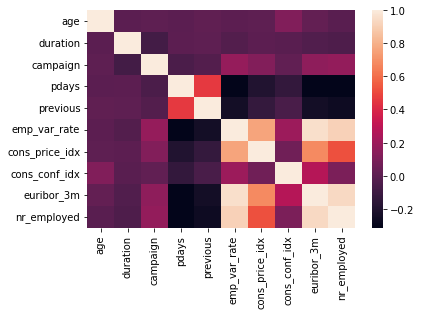

In [58]:
correlation = bank_data.corr()
sns.heatmap(correlation)

## Hypothesis Testing

### Chi_square test

In [59]:
from scipy.stats import chi2_contingency

hypo_cat_columns = ["default","housing","loan","job","education"]

for column in hypo_cat_columns:
    ctab = pd.crosstab(bank_data["y"], bank_data[column])
    test_statistic, p_value, df, expected_frequencies = chi2_contingency(ctab)
    print("p_value for ",column," ", p_value)
    print("--------------------------------")

p_value for  default   4.8329241546266e-06
--------------------------------
p_value for  housing   7.158240160949871e-89
--------------------------------
p_value for  loan   2.187772147510664e-29
--------------------------------
p_value for  job   0.0
--------------------------------
p_value for  education   2.1538360537370596e-80
--------------------------------


### Annova_test

In [60]:
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [61]:
# Annova test for age column
agr_ols = ols("age ~ y", data=bank_data).fit()
table = anova_lm(agr_ols, typ=2)
print(table)

                sum_sq       df          F        PR(>F)
y         7.450942e+03      1.0  67.187133  2.502618e-16
Residual  9.581285e+06  86397.0        NaN           NaN


In [62]:
# Annova test for duration column
agr_ols = ols("duration ~ y", data=bank_data).fit()
table = anova_lm(agr_ols, typ=2)
print(table)

                sum_sq       df             F  PR(>F)
y         9.208287e+08      1.0  16415.822729     0.0
Residual  4.846351e+09  86397.0           NaN     NaN


### Annova tuckey's test

In [63]:
compare = pairwise_tukeyhsd(bank_data['age'], 
                            bank_data['y'], alpha=0.05)

result = pd.DataFrame(compare._results_table.data)
result

,0,1,2,3,4,5,6
0,group1,group2,meandiff,p-adj,lower,upper,reject
1,no,yes,0.9208,0.0,0.7006,1.141,True


In [64]:
compare = pairwise_tukeyhsd(bank_data['duration'], 
                            bank_data['y'], alpha=0.05)

result = pd.DataFrame(compare._results_table.data)
result

,0,1,2,3,4,5,6
0,group1,group2,meandiff,p-adj,lower,upper,reject
1,no,yes,323.7021,0.0,318.7502,328.6539,True


## Data_preprocessing

In [65]:
# Creating a dictionary for converting categorical textual data entries
# into categorical numeric on basis of job profile
job_dict = {"entrepreneur":11, "self-employed":10, "admin":9, "management":8, "services":7, 
       "technician":6, "blue-collar":5, "housemaid":4, "retired":3, "student":2, "unemployed":1}

In [66]:
bank_data["jobs"] = bank_data["job"].map(job_dict)
bank_data = bank_data.drop("job", axis=1)

In [67]:
bank_data.head()

,age,marital,education,default,housing,loan,contact,date,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y,jobs
0,56,married,basic_4y,no,no,no,telephone,2008-5-05,261,1,-1,0,failure,1.1,93.994,-36.4,4.857,5191.0,no,4
1,57,married,high_school,no,no,no,telephone,2008-5-05,149,1,-1,0,failure,1.1,93.994,-36.4,4.857,5191.0,no,7
2,37,married,high_school,no,yes,no,telephone,2008-5-05,226,1,-1,0,failure,1.1,93.994,-36.4,4.857,5191.0,no,7
3,40,married,basic_6y,no,no,no,telephone,2008-5-05,151,1,-1,0,failure,1.1,93.994,-36.4,4.857,5191.0,no,9
4,56,married,high_school,no,no,yes,telephone,2008-5-05,307,1,-1,0,failure,1.1,93.994,-36.4,4.857,5191.0,no,7


In [68]:
marital_dict = {"married":3, "single":2, "divorced":1}
bank_data["maritals"] = bank_data["marital"].map(marital_dict)
bank_data = bank_data.drop("marital", axis=1)
bank_data.head()

,age,education,default,housing,loan,contact,date,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y,jobs,maritals
0,56,basic_4y,no,no,no,telephone,2008-5-05,261,1,-1,0,failure,1.1,93.994,-36.4,4.857,5191.0,no,4,3
1,57,high_school,no,no,no,telephone,2008-5-05,149,1,-1,0,failure,1.1,93.994,-36.4,4.857,5191.0,no,7,3
2,37,high_school,no,yes,no,telephone,2008-5-05,226,1,-1,0,failure,1.1,93.994,-36.4,4.857,5191.0,no,7,3
3,40,basic_6y,no,no,no,telephone,2008-5-05,151,1,-1,0,failure,1.1,93.994,-36.4,4.857,5191.0,no,9,3
4,56,high_school,no,no,yes,telephone,2008-5-05,307,1,-1,0,failure,1.1,93.994,-36.4,4.857,5191.0,no,7,3


In [69]:
edu_dict = {"professional_course":10, "university_degree":9, "tertiary":8, "secondary":7, 
       "high_school":6, "basic_9y":5, "basic_6y":4, "primary":3, "basic_4y":2, "illiterate":1}
bank_data["education"] = bank_data["education"].map(edu_dict)
#new_data = new_data.drop("marital", axis=1)
bank_data.head()

,age,education,default,housing,loan,contact,date,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y,jobs,maritals
0,56,2,no,no,no,telephone,2008-5-05,261,1,-1,0,failure,1.1,93.994,-36.4,4.857,5191.0,no,4,3
1,57,6,no,no,no,telephone,2008-5-05,149,1,-1,0,failure,1.1,93.994,-36.4,4.857,5191.0,no,7,3
2,37,6,no,yes,no,telephone,2008-5-05,226,1,-1,0,failure,1.1,93.994,-36.4,4.857,5191.0,no,7,3
3,40,4,no,no,no,telephone,2008-5-05,151,1,-1,0,failure,1.1,93.994,-36.4,4.857,5191.0,no,9,3
4,56,6,no,no,yes,telephone,2008-5-05,307,1,-1,0,failure,1.1,93.994,-36.4,4.857,5191.0,no,7,3


In [70]:
bank_data.head()

,age,education,default,housing,loan,contact,date,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y,jobs,maritals
0,56,2,no,no,no,telephone,2008-5-05,261,1,-1,0,failure,1.1,93.994,-36.4,4.857,5191.0,no,4,3
1,57,6,no,no,no,telephone,2008-5-05,149,1,-1,0,failure,1.1,93.994,-36.4,4.857,5191.0,no,7,3
2,37,6,no,yes,no,telephone,2008-5-05,226,1,-1,0,failure,1.1,93.994,-36.4,4.857,5191.0,no,7,3
3,40,4,no,no,no,telephone,2008-5-05,151,1,-1,0,failure,1.1,93.994,-36.4,4.857,5191.0,no,9,3
4,56,6,no,no,yes,telephone,2008-5-05,307,1,-1,0,failure,1.1,93.994,-36.4,4.857,5191.0,no,7,3


In [71]:
# Convert the date column to a datetime object
bank_data['date'] = pd.to_datetime(bank_data['date'])

# Add a new column with the quarter based on the date values
bank_data['quarter'] = bank_data['date'].apply(lambda x: "q"+str((x.month-1)//3 + 1))

bank_data.head()

,age,education,default,housing,loan,contact,date,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y,jobs,maritals,quarter
0,56,2,no,no,no,telephone,2008-05-05,261,1,-1,0,failure,1.1,93.994,-36.4,4.857,5191.0,no,4,3,q2
1,57,6,no,no,no,telephone,2008-05-05,149,1,-1,0,failure,1.1,93.994,-36.4,4.857,5191.0,no,7,3,q2
2,37,6,no,yes,no,telephone,2008-05-05,226,1,-1,0,failure,1.1,93.994,-36.4,4.857,5191.0,no,7,3,q2
3,40,4,no,no,no,telephone,2008-05-05,151,1,-1,0,failure,1.1,93.994,-36.4,4.857,5191.0,no,9,3,q2
4,56,6,no,no,yes,telephone,2008-05-05,307,1,-1,0,failure,1.1,93.994,-36.4,4.857,5191.0,no,7,3,q2


quarters = ["Q1", "Q2", "Q3", "Q4"]
months = [["jan","feb","mar"],["apr","may","jun"],["jul","aug","sep"],["oct","nov","dec"]]

for i in range(0,4):
    new_data["month"] = new_data["month"].replace(months[i], quarters[i])

new_data["month"].unique()

In [72]:
bank_data["y"] = bank_data["y"].replace("yes", 1)
bank_data["y"] = bank_data["y"].replace("no", 0)

In [73]:
bank_data = pd.get_dummies(data = bank_data, drop_first = True)
bank_data.head(5)

,age,education,date,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y,jobs,maritals,default_yes,housing_yes,loan_yes,contact_telephone,poutcome_other,poutcome_success,quarter_q2,quarter_q3,quarter_q4
0,56,2,2008-05-05,261,1,-1,0,1.1,93.994,-36.4,4.857,5191.0,0,4,3,0,0,0,1,0,0,1,0,0
1,57,6,2008-05-05,149,1,-1,0,1.1,93.994,-36.4,4.857,5191.0,0,7,3,0,0,0,1,0,0,1,0,0
2,37,6,2008-05-05,226,1,-1,0,1.1,93.994,-36.4,4.857,5191.0,0,7,3,0,1,0,1,0,0,1,0,0
3,40,4,2008-05-05,151,1,-1,0,1.1,93.994,-36.4,4.857,5191.0,0,9,3,0,0,0,1,0,0,1,0,0
4,56,6,2008-05-05,307,1,-1,0,1.1,93.994,-36.4,4.857,5191.0,0,7,3,0,0,1,1,0,0,1,0,0


In [74]:
outliers_columns = ["age","duration","campaign","pdays","previous"]

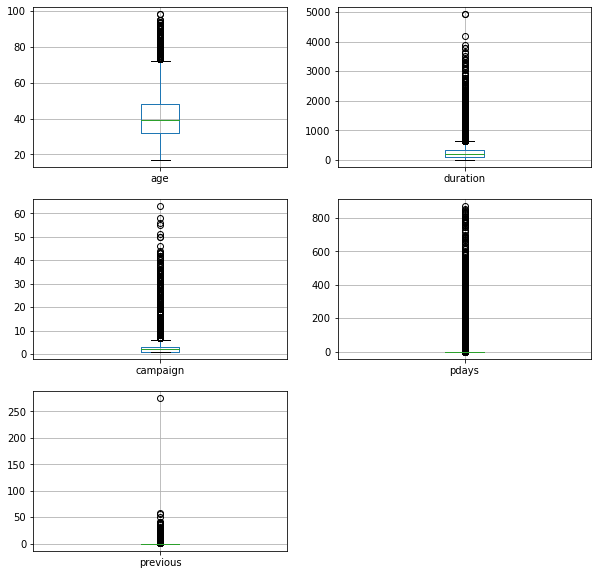

In [75]:
def plot_box():
    plt.figure(figsize=(10,10))
    plt.subplot(3,2,1)
    bank_data.boxplot(column=["age"])

    plt.subplot(3,2,2)
    bank_data.boxplot(column=["duration"])

    plt.subplot(3,2,3)
    bank_data.boxplot(column=["campaign"])

    plt.subplot(3,2,4)
    bank_data.boxplot(column=["pdays"])

    plt.subplot(3,2,5)
    bank_data.boxplot(column=["previous"])
           
plot_box()

In [76]:
max_out_limit = []
for cols in outliers_columns:
    q3 = bank_data[cols].quantile(0.75)
    q1 = bank_data[cols].quantile(0.25)
    iqr = q3 - q1
    iqr = iqr*1.5
    max_limit = q3 + iqr
    min_limit = q1 - iqr
    max_out_limit.append(max_limit)
    print(cols, "max_limit: ",max_limit," min_limit: ",min_limit)
else:
    print("------------------------------------------")
    print(max_out_limit)

age max_limit:  72.0  min_limit:  8.0
duration max_limit:  643.0  min_limit:  -221.0
campaign max_limit:  6.0  min_limit:  -2.0
pdays max_limit:  -1.0  min_limit:  -1.0
previous max_limit:  0.0  min_limit:  0.0
------------------------------------------
[72.0, 643.0, 6.0, -1.0, 0.0]


In [77]:
for i, j in zip(outliers_columns, max_out_limit):
    bank_data.loc[bank_data[i]>=j, i]=j

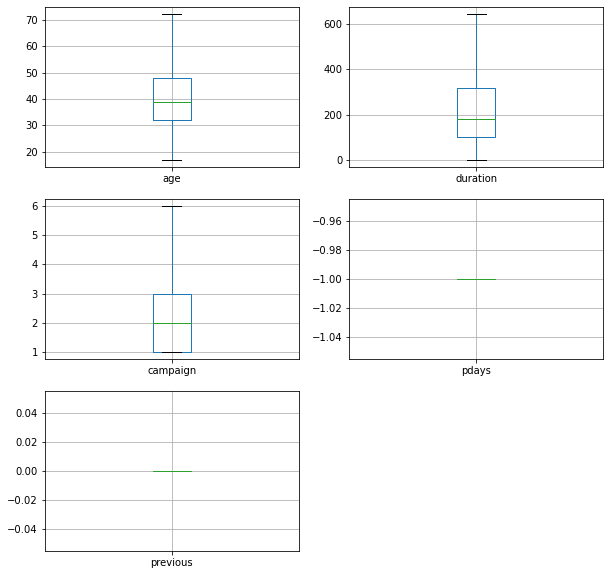

In [78]:
plot_box()

In [79]:
bank_data = bank_data.drop(["date"],axis = 1)

In [80]:
features = []
for columns in bank_data:
    features.append(columns)
else:
    print(features)

['age', 'education', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'y', 'jobs', 'maritals', 'default_yes', 'housing_yes', 'loan_yes', 'contact_telephone', 'poutcome_other', 'poutcome_success', 'quarter_q2', 'quarter_q3', 'quarter_q4']


In [81]:
bank_data.head()

,age,education,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y,jobs,maritals,default_yes,housing_yes,loan_yes,contact_telephone,poutcome_other,poutcome_success,quarter_q2,quarter_q3,quarter_q4
0,56,2,261,1,-1,0,1.1,93.994,-36.4,4.857,5191.0,0,4,3,0,0,0,1,0,0,1,0,0
1,57,6,149,1,-1,0,1.1,93.994,-36.4,4.857,5191.0,0,7,3,0,0,0,1,0,0,1,0,0
2,37,6,226,1,-1,0,1.1,93.994,-36.4,4.857,5191.0,0,7,3,0,1,0,1,0,0,1,0,0
3,40,4,151,1,-1,0,1.1,93.994,-36.4,4.857,5191.0,0,9,3,0,0,0,1,0,0,1,0,0
4,56,6,307,1,-1,0,1.1,93.994,-36.4,4.857,5191.0,0,7,3,0,0,1,1,0,0,1,0,0


In [82]:
tele_copy = bank_data.copy()
tele_copy.to_csv("bank_spark.csv")

### Machine Learning Model

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

In [84]:
df = pd.read_csv("bank_spark.csv")

In [85]:
# Data oversampling function of the "yes" lebel in the dependent column
def over_sample( data, oversampling_ratio ):
    """
        This method takes in an imbalanced dataframe and it returns a
        new dataframe with oversampled minority rows according to the
        oversampling ratio provided.
    """
    import math

    # avoid changing the original object accidentally
    new_data = data
    

    nums = new_data['y'].value_counts()
    num_n = nums[0]
    num_y = nums[1]
    nums = len(new_data["y"])

    new_y = ( (1 - oversampling_ratio) / oversampling_ratio)*num_n
   
    loop_num = int( math.ceil(new_y/num_y) )

    new_df = new_data[ new_data["y"] == 1.0 ]
   
    for i in range(0, loop_num-1):
       
        # randomly select all rows from new_df
        random_rows = new_df.sample(n = num_y, replace=True, random_state = 14)
        
        # append the selected row to bank_df
        new_data = new_data.append(random_rows, ignore_index=True)
       
    return new_data

In [86]:
df2 = over_sample(data = df, oversampling_ratio = 0.6)

C:\Users\DELL\AppData\Local\Temp\ipykernel_6544\2798388396.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_data = new_data.append(random_rows, ignore_index=True)


In [87]:
df2["y"].value_counts()

0    76470
1    59574
Name: y, dtype: int64

In [88]:
x = df2.drop(["y","Unnamed: 0","pdays","previous","emp_var_rate","cons_price_idx","cons_conf_idx","euribor_3m","nr_employed"], axis=1)
y = df2["y"]

In [89]:
x.head()

,age,education,duration,campaign,jobs,maritals,default_yes,housing_yes,loan_yes,contact_telephone,poutcome_other,poutcome_success,quarter_q2,quarter_q3,quarter_q4
0,56,2,261,1,4,3,0,0,0,1,0,0,1,0,0
1,57,6,149,1,7,3,0,0,0,1,0,0,1,0,0
2,37,6,226,1,7,3,0,1,0,1,0,0,1,0,0
3,40,4,151,1,9,3,0,0,0,1,0,0,1,0,0
4,56,6,307,1,7,3,0,0,1,1,0,0,1,0,0


In [90]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

In [91]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 2022, test_size = 0.25)

### Logistic Regression

In [92]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_prob = lr.predict_proba(x_test)[:,1]

print(accuracy_score(y_test, y_pred))
print(roc_auc_score(y_test, y_pred_prob))

0.7990944106318544
0.8785219407703105


In [93]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
rf_pred = rfc.predict(x_test)
rf_pred_prob = rfc.predict_proba(x_test)[:,1]

print(accuracy_score(y_test, rf_pred))
print(roc_auc_score(y_test, rf_pred_prob))

0.9543971068183823
0.9915205615121554


In [94]:
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
y_pred_prob = dtc.predict_proba(x_test)[:,1]

print(accuracy_score(y_test, y_pred))
print(roc_auc_score(y_test, y_pred_prob))

0.9343741730616565
0.9373848893739868


In [95]:
voting = VotingClassifier([('LR',lr),('RFC',rfc),('DTC',dtc)],voting='soft')
voting.fit(x_train, y_train)
y_pred = voting.predict(x_test)
y_pred_prob = voting.predict_proba(x_test)[:,1]

print(accuracy_score(y_test, y_pred))
print(roc_auc_score(y_test, y_pred_prob))

0.9429008262032872
0.9828801585989047


In [96]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

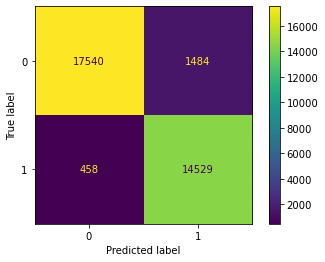

In [97]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [98]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.92      0.95     19024
           1       0.91      0.97      0.94     14987

    accuracy                           0.94     34011
   macro avg       0.94      0.95      0.94     34011
weighted avg       0.94      0.94      0.94     34011



In [99]:
import pickle
file = open('Bank_model.pkl', 'wb')
pickle.dump(rfc , file)
file.close()

In [100]:
#Output_prediction = rfc.predict([[1.362875,2.3,-0.222296,-0.808212,-1.064111,0.779461,-0.090822,-1.039196,-0.408213,2.17499,-0.156688,-0.31279,1.06219,-0.684129,-0.388654]])
print(Output_prediction)

[0]


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
